# Future Vision Transport - Segmentation pipeline
Pipeline end-to-end : données Cityscapes → mapping 8 classes → entraînement Keras → logs MLflow.

In [ ]:
# Smoke test pour valider le mapping 
import sys
from pathlib import Path
import tensorflow as tf
import mlflow, mlflow.tensorflow

# Assure le PYTHONPATH
sys.path.append(str(Path("src").resolve()))
from fvt.training.config import TrainingConfig
from fvt.training.pipeline import build_model
from fvt.data.dataset_builder import build_dataset

# Config mini
cfg = TrainingConfig(
    input_height=192, input_width=384,
    batch_size=1,
    epochs=1,
    run_name="smoke_mapping_ultra_mlflow",
)
# Datasets échantillonnés
train_ds = build_dataset(
    Path(cfg.train_images), Path(cfg.train_masks),
    target_size=(cfg.input_height, cfg.input_width),
    batch_size=cfg.batch_size, shuffle=True,
    augment=False, num_classes=cfg.num_classes,
).take(20)
val_ds = build_dataset(
    Path(cfg.val_images), Path(cfg.val_masks),
    target_size=(cfg.input_height, cfg.input_width),
    batch_size=cfg.batch_size, shuffle=False,
    augment=False, num_classes=cfg.num_classes,
).take(5)

mlflow.set_tracking_uri("http://localhost:5000")  # ajuste si besoin
mlflow.set_experiment(cfg.experiment_name)
mlflow.tensorflow.autolog(log_models=False)

with mlflow.start_run(run_name=cfg.run_name):
    model = build_model(cfg)
    history = model.fit(train_ds, validation_data=val_ds, epochs=cfg.epochs)
    # log model + sauvegarde locale
    model.save("artifacts/models/smoke_saved_model", include_optimizer=False)
    mlflow.keras.log_model(
        model,
        artifact_path="model",
        registered_model_name=cfg.experiment_name,
        input_example=tf.zeros((1,) + cfg.input_shape()).numpy(),
    )
    mlflow.log_param("smoke_take_train", 20)
    mlflow.log_param("smoke_take_val", 5)

print("Smoke model saved to artifacts/models/smoke_saved_model")


In [ ]:
import sys
from pathlib import Path
import tensorflow as tf
import mlflow, mlflow.tensorflow

# PYTHONPATH
sys.path.append(str(Path("src").resolve()))
from fvt.training.config import TrainingConfig
from fvt.training.pipeline import build_model
from fvt.data.dataset_builder import build_dataset

# Config mini
cfg = TrainingConfig(
    input_height=192,
    input_width=384,
    batch_size=1,
    epochs=1,
    run_name="smoke_nb_mlflow",
)

# Datasets échantillonnés
train_ds = build_dataset(
    Path(cfg.train_images), Path(cfg.train_masks),
    target_size=(cfg.input_height, cfg.input_width),
    batch_size=cfg.batch_size, shuffle=True,
    augment=False, num_classes=cfg.num_classes,
).take(20)
val_ds = build_dataset(
    Path(cfg.val_images), Path(cfg.val_masks),
    target_size=(cfg.input_height, cfg.input_width),
    batch_size=cfg.batch_size, shuffle=False,
    augment=False, num_classes=cfg.num_classes,
).take(5)

# MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # ajuste si besoin
mlflow.set_experiment(cfg.experiment_name)
mlflow.tensorflow.autolog(log_models=False)

with mlflow.start_run(run_name=cfg.run_name):
    model = build_model(cfg)
    model.fit(train_ds, validation_data=val_ds, epochs=cfg.epochs)
    model.save("artifacts/models/smoke_saved_model_tmp", include_optimizer=False)
    mlflow.keras.log_model(
        model,
        artifact_path="model",
        registered_model_name=cfg.experiment_name,
        input_example=tf.zeros((1,) + cfg.input_shape()).numpy(),
    )
    mlflow.log_param("smoke_take_train", 20)
    mlflow.log_param("smoke_take_val", 5)

print("Smoke model saved to artifacts/models/smoke_saved_model_tmp")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from fvt.data.labels import colorize
from fvt.data.dataset_builder import build_dataset

# Recharge le modèle smoke (ou utilise `model` si tu es dans la même session)
model = tf.keras.models.load_model("artifacts/models/smoke_saved_model")

val_ds = build_dataset(
    Path(cfg.val_images), Path(cfg.val_masks),
    target_size=(cfg.input_height, cfg.input_width),
    batch_size=1, shuffle=False, augment=False, num_classes=cfg.num_classes,
).take(3)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, (img, mask, _) in enumerate(val_ds):
    # mask GT remappé vers 7 classes
    mask_gt_idx = tf.argmax(mask[0], axis=-1).numpy().astype("uint8")
    mask_gt_rgb = colorize(mask_gt_idx)
    # prédiction¨
    logits = model(img, training=False)
    pred_idx = tf.argmax(logits, axis=-1)[0].numpy().astype("uint8")
    pred_rgb = colorize(pred_idx)

    axes[i,0].imshow(img[0]); axes[i,0].set_title("Image"); axes[i,0].axis("off")
    axes[i,1].imshow(mask_gt_rgb); axes[i,1].set_title("Mask réel"); axes[i,1].axis("off")
    axes[i,2].imshow(pred_rgb); axes[i,2].set_title("Mask prédit"); axes[i,2].axis("off")

plt.tight_layout()
plt.show()


In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("src").resolve()))
import mlflow
import os, sys

os.chdir("/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport")
sys.path.insert(0, str(Path.cwd() / "src"))


from fvt.config import load_settings
from fvt.data.dataset_builder import build_dataset
from fvt.training.config import TrainingConfig
from fvt.training.pipeline import train_segmentation_model


2025-12-04 17:56:45.871160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
settings = load_settings()
config = TrainingConfig()

mlflow.set_tracking_uri(settings.mlflow_tracking_uri)
mlflow.set_experiment(config.experiment_name)
settings, config

2025/12/04 17:57:38 INFO mlflow.tracking.fluent: Experiment with name 'future_vision_segmentation' does not exist. Creating a new experiment.


(Settings(project_root=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport'), data_root=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/data'), downloads_dir=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/data/downloads'), raw_dir=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/data/raw'), processed_dir=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/data/processed'), interim_dir=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/data/interim'), mlruns_dir=PosixPath('/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/mlruns'), mlflow_tracking_uri='/Users/pierre/OpenClassroomAIEngineer/Projets/Future Vision Transport/mlruns', mlflow_experiment='future_vision_segmentation'),
 TrainingConfig(input_height=512, input_width=1024, num_classes=7, batch_size=2, epochs=20, learning_rate=0

In [3]:
# Aperçu du dataset (ajustez les chemins si besoin)
train_ds = build_dataset(
    Path(config.train_images),
    Path(config.train_masks),
    target_size=(config.input_height, config.input_width),
    batch_size=2,
    shuffle=False,
    augment=False,
    num_classes=config.num_classes,
)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 1024, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 1024), dtype=tf.float32, name=None))>

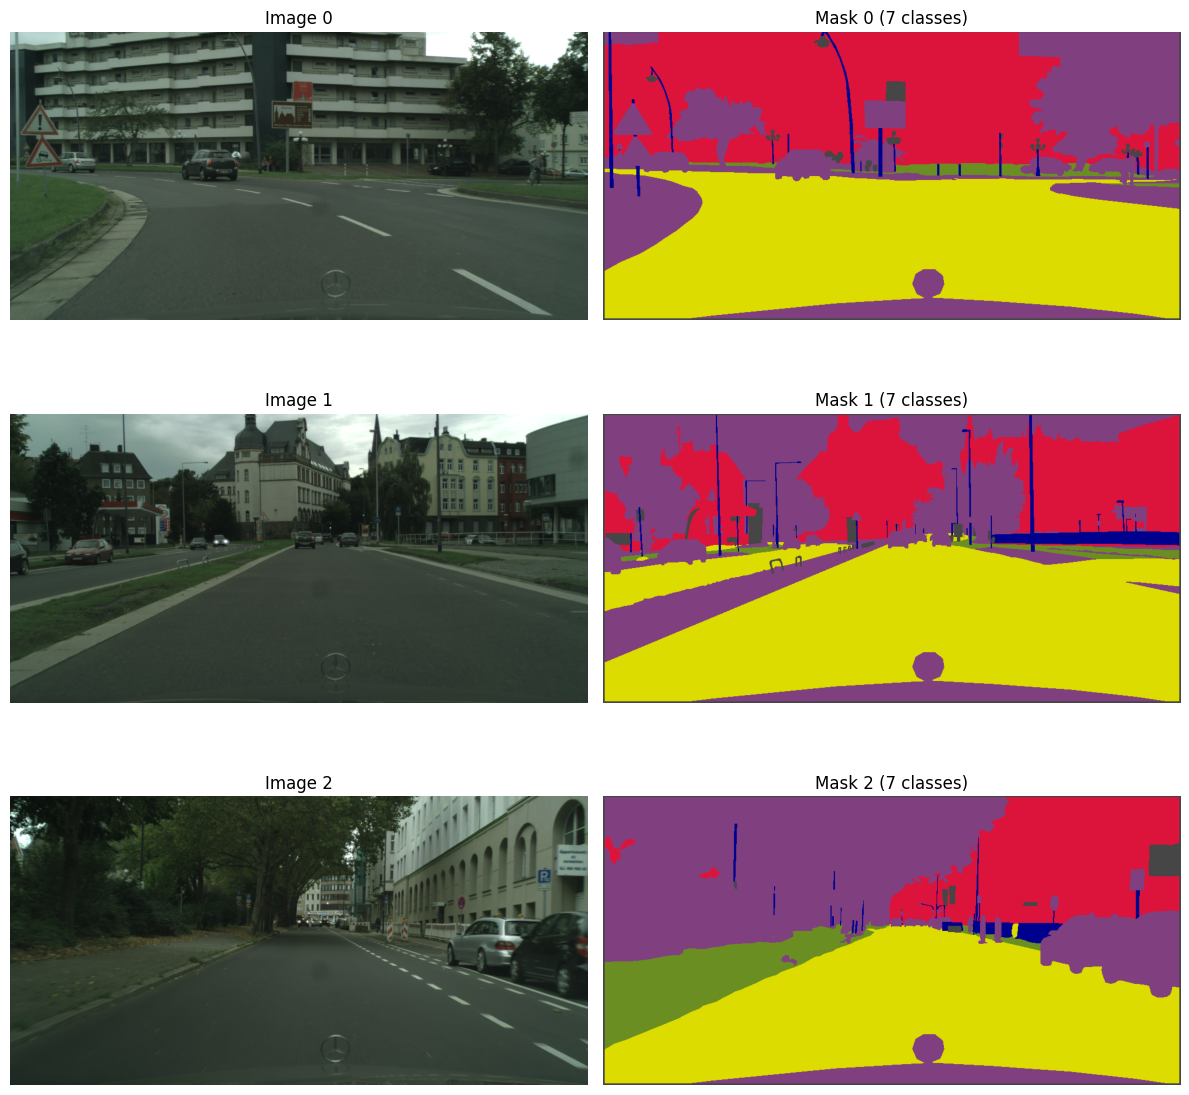

In [6]:
import matplotlib.pyplot as plt
from fvt.data.labels import colorize
import tensorflow as tf

n = 3  # nombre d’images à afficher
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

for i, (img, mask, _) in enumerate(ds.take(n)):
    mask_idx = tf.argmax(mask[0], axis=-1).numpy().astype("uint8")
    mask_rgb = colorize(mask_idx)

    axes[i, 0].imshow(img[0]); axes[i, 0].set_title(f"Image {i}"); axes[i, 0].axis("off")
    axes[i, 1].imshow(mask_rgb); axes[i, 1].set_title(f"Mask {i} (7 classes)"); axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [7]:
from pathlib import Path
from fvt.training.config import TrainingConfig
from fvt.training.pipeline import build_model
from fvt.inference.predict import preprocess_image, predict_mask
from fvt.data.labels import colorize
from PIL import Image

cfg = TrainingConfig()
model = build_model(cfg)
model.load_weights("artifacts/checkpoints/<ton_checkpoint>.weights.h5")

image = preprocess_image(Path("<ton_image>.png"), (cfg.input_height, cfg.input_width))
mask_idx, _ = predict_mask(model, image, num_classes=cfg.num_classes)
Image.fromarray(colorize(mask_idx)).save("artifacts/pred_mask.png")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'artifacts/checkpoints/<ton_checkpoint>.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
# Entraînement + log MLflow (autolog activé dans la pipeline)
history = train_segmentation_model(config, settings)
history.history.keys()

Epoch 1/20


2025/12/04 17:58:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='2' for run ID='63293c00c6f342638e61271aa1a21926'. Attempted logging new value 'None'.


KeyboardInterrupt: 

In [ ]:

# TOOLBOX :
# Récupération du run mal loggué

#export 
PYTHONPATH=src
#exporrt
MLFLOW_TRACKING_URI=http://localhost:5000
#python3 - <<'PY'
from pathlib import Path
import tensorflow as tf
import mlflow
from mlflow.tracking import MlflowClient
from fvt.training.config import TrainingConfig
import spicy

SOURCE_RUN = "<recup_run_id>"  # à renseigner
saved_model_dir = Path("artifacts/models/saved_model")

client = MlflowClient()
src = client.get_run(SOURCE_RUN)
exp_name = src.info.experiment_id  # même expérience
start_ts = src.info.start_time
end_ts = src.info.end_time  # peut être None si pas d’end_time; dans ce cas on laissera mlflow mettre maintenant

# Création d’un nouveau run en réutilisant le start_time
new_run = client.create_run(experiment_id=exp_name, start_time=start_ts, tags={"source_run_id": SOURCE_RUN})
new_id = new_run.info.run_id

cfg = TrainingConfig()
with mlflow.start_run(run_id=new_id):
    mlflow.log_params({
        "input_height": cfg.input_height,
        "input_width": cfg.input_width,
        "num_classes": cfg.num_classes,
    })
    model = tf.keras.models.load_model(saved_model_dir)
    mlflow.keras.log_model(
        model,
        artifact_path="model",
        registered_model_name=cfg.experiment_name,
        input_example=tf.zeros((1,) + cfg.input_shape()).numpy(),
    )

# Clôture en fixant l’end_time du run source si disponible
client.set_terminated(new_id, status="FINISHED", end_time=end_ts)
print("New run id:", new_id, "start/end copied from source.")
#PY


In [9]:
# ToolBox
# On peut dupliquer les artefacts du run source vers le nouveau run en Python via l’API MLflow.
# Voici un script à exécuter depuis la racine (en remplaçant SOURCE_RUN et TARGET_RUN) :
#export 
PYTHONPATH=src
#export 
# 
MLFLOW_TRACKING_URI=http://localhost:5000

#python3 - <<'PY'
import shutil, tempfile
from pathlib import Path
import mlflow
from mlflow.tracking import MlflowClient

SOURCE_RUN = "3b9679dfb26e4906874b9ba7277c54ca"
TARGET_RUN = "7a158687a99a44b984ffcda0e5ee2426"

mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

# Copier params/tags du run source vers le run cible (sans écraser ce qui existe déjà)
src = client.get_run(SOURCE_RUN)
for k,v in src.data.params.items():
    client.log_param(TARGET_RUN, k, v)
for k,v in src.data.tags.items():
    if k not in {"mlflow.runName","mlflow.source.name","mlflow.source.git.commit"}:
        client.set_tag(TARGET_RUN, k, v)

# Copier artefacts
with tempfile.TemporaryDirectory() as tmpdir:
    local_dir = client.download_artifacts(SOURCE_RUN, "", tmpdir)
    for p in Path(local_dir).rglob("*"):
        if p.is_file():
            rel = p.relative_to(local_dir)
            client.log_artifact(TARGET_RUN, str(p), artifact_path=str(rel.parent) if rel.parent != Path(".") else None)

print("Copie terminée.")
#PY


SyntaxError: invalid syntax (2708775918.py, line 8)

## À compléter
- EDA rapide (distribution des classes, palette)
- Validation qualitative (afficher image + mask réel + mask prédit)
- Essais d'augmentations et suivi mIoU par classe
- Export bundle modèle + palette pour l'API